In [1]:
import pandas as pd
import numpy as np

from sklearn import ensemble

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesDummiesOrdinal.csv')

In [2]:
#Load the RF and XGB features, which contains the list of Features to include in the linear model:
rfFeatures = pd.read_csv('rfFeatures.csv')
xgbFeatures = pd.read_csv('xgbFeatures.csv')

lst = [rfFeatures, xgbFeatures]
for df in lst:
    df.columns = ['Feature','Score']

In [3]:
rfFeatures.head()

,Feature,Score
0,OverallQual,0.650761
1,TotalSF,0.140105
2,TotalBsmtSF,0.062907
3,BsmtScore,0.022469
4,TotalBath,0.018086


In [4]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = pd.concat([AmesDummiesOrdinal[list(rfFeatures['Feature'])],AmesDummiesOrdinal[['SalePrice']]], axis=1)

In [5]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [6]:
#Reset indices of AmesDF
AmesDF.index = range(1166)

In [7]:
#Initiate K-fold (n=5) cross-validation model to train/test:

import sklearn.model_selection as ms
ms_k5 = ms.KFold(n_splits=5, shuffle=True)

In [8]:
from sklearn.model_selection import RandomizedSearchCV

#We will perform a grid search to find the optimal hyperparameters for our RF algorithm and test using our K-fold data:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
randomForest = ensemble.RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randomForest_random = RandomizedSearchCV(estimator = randomForest, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
randomForest_random.fit(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Then print the best parameters using best_params_
randomForest_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.3s
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.8min finished


{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [9]:
#The RandomizedSearchCV algorithm found n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, and bootstrap=False as the best set of parameters. Let's use these for our analysis
randomForest2 = ensemble.RandomForestRegressor()
randomForest2.set_params(bootstrap=False, max_depth=70, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, 
                        n_estimators=800)
randomForest2

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=70,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []

for train, test in AmesDF5Fold:
    #Run the fit using the train data for each K
    randomForest2.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = randomForest2.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = randomForest2.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = randomForest2.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = randomForest2.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)

In [11]:
#What are the R^2 values for our runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.8854811543218875, 0.8942588384651041, 0.9319274731801174, 0.8798439727987128, 0.8934642187538065]
[0.8986649064222176, 0.8979281765311504, 0.8987545290425807, 0.9014272109962622, 0.898086645494765]
[0.13658046785848996, 0.13502683186758507, 0.13452906163667647, 0.135484492297904, 0.1370536848716215]


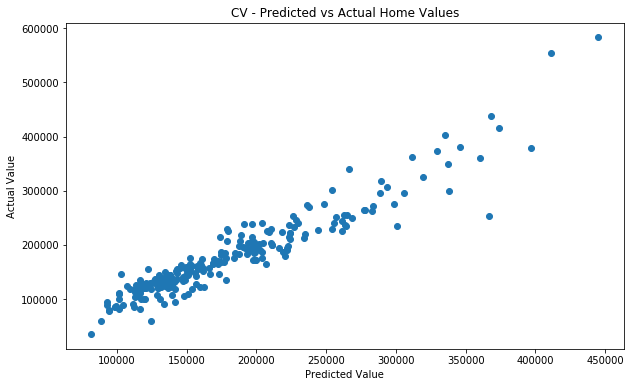

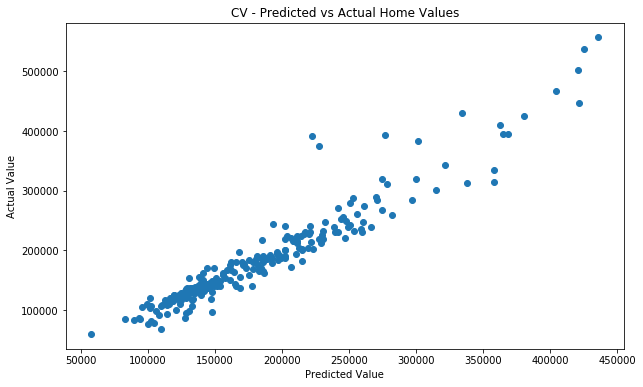

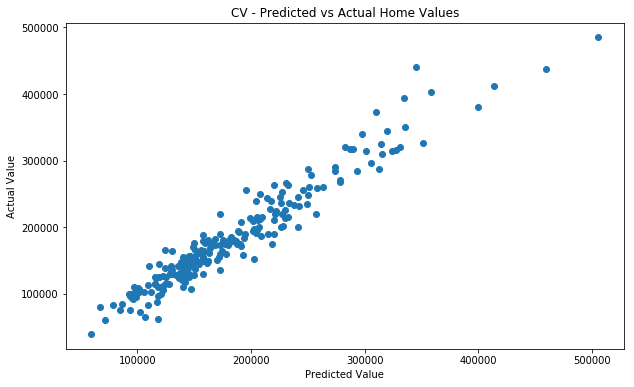

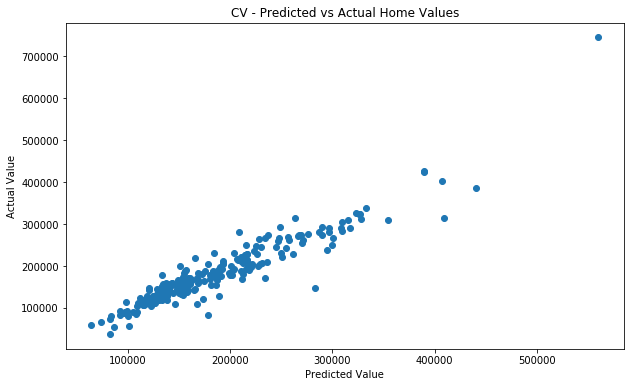

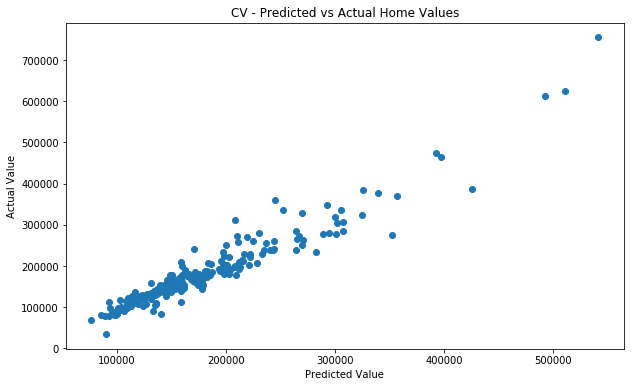

In [13]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [14]:
#As we did in the lienar model, what would this look like for only 2 folds (50/50 split between groups?)
ms_k2 = ms.KFold(n_splits=2, shuffle=True)

#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF2Fold = ms_k2.split(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2ListN2 = []
PredictListN2 = []
ActualListN2 = []
PureTestR2N2 = []
RMSLE = []

for train, test in AmesDF2Fold:
    randomForest2.fit(X.iloc[train,], Y[train])
    p = randomForest2.predict(X.iloc[test,])
    R2 = randomForest2.score(X.iloc[test,], Y[test])
    TestR2 = randomForest2.score(testX, testY)
    R2ListN2.append(R2)
    PureTestR2N2.append(TestR2)
    PredictListN2.append(p)
    ActualListN2.append(Y[test])
    PredictionsTest = randomForest2.predict(testX)
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)

In [15]:
#What are the R^2 scores for each of our 2 runs? Still a fairly good 79% and 86% R^2 value.
print(R2ListN2)
print(PureTestR2N2)
print(RMSLE)

[0.8759175053758397, 0.858124988740778]
[0.8895229538683069, 0.892924917240862]
[0.13922729940917922, 0.14134527161327098]


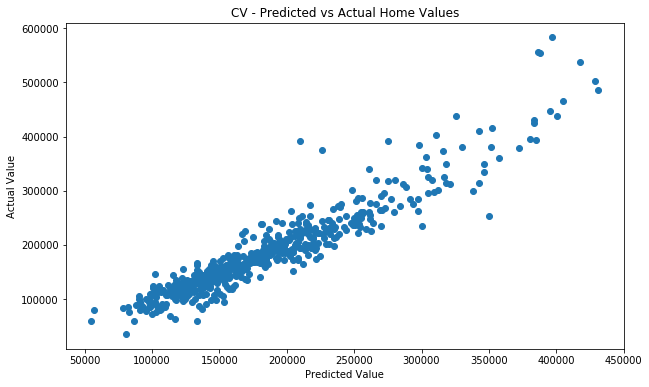

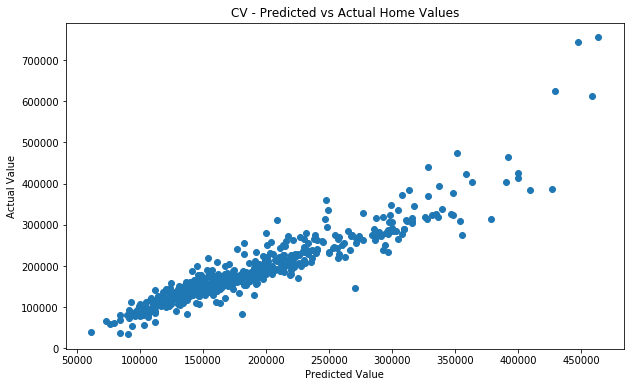

In [16]:
#Let's plot these:
for i in range(len(PredictListN2)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictListN2[i], ActualListN2[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')
    plt.show()

### XGBoost

In [19]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesxDF = pd.concat([AmesDummiesOrdinal[list(xgbFeatures['Feature'])],AmesDummiesOrdinal[['SalePrice']]], axis=1)

In [20]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesxDF2 = AmesxDF.copy()
AmesxDF = AmesxDF.iloc[trainIdxes,]
AmesxDFTest = AmesxDF2.iloc[testIdxes,]

In [21]:
#Reset indices of AmesDF
AmesxDF.index = range(1166)

In [22]:
#Initiate K-fold (n=5) cross-validation model to train/test:

import sklearn.model_selection as ms
ms_k5 = ms.KFold(n_splits=5, shuffle=True)

In [23]:
from sklearn.model_selection import RandomizedSearchCV

#We will perform a grid search to find the optimal hyperparameters for our RF algorithm and test using our K-fold data:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
randomForest = ensemble.RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randomForest_random = RandomizedSearchCV(estimator = randomForest, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
randomForest_random.fit(AmesxDF.drop('SalePrice', axis=1), AmesxDF['SalePrice'])

#Then print the best parameters using best_params_
randomForest_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.6s
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.5min finished


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [24]:
#The RandomizedSearchCV algorithm found n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, and bootstrap=False as the best set of parameters. Let's use these for our analysis
randomForest2 = ensemble.RandomForestRegressor()
randomForest2.set_params(bootstrap=False, max_depth=90, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, 
                        n_estimators=400)
randomForest29

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=70,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesxDF.drop('SalePrice', axis=1)
Y = AmesxDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesxDFTest.drop('SalePrice', axis=1)
testY = AmesxDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(AmesxDF.drop('SalePrice', axis=1), AmesxDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []

for train, test in AmesDF5Fold:
    #Run the fit using the train data for each K
    randomForest2.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = randomForest2.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = randomForest2.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = randomForest2.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = randomForest2.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)

In [27]:
#What are the R^2 values for our runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.8874073493463089, 0.8868700589052001, 0.9343759542220776, 0.871434466329612, 0.8735474540324795]
[0.9018895356862151, 0.8994517506849082, 0.8998443248635442, 0.9027661031181677, 0.8967705525360335]
[0.13552821936648468, 0.13459525104673903, 0.13381893347980223, 0.13489656973661968, 0.13657251155393382]


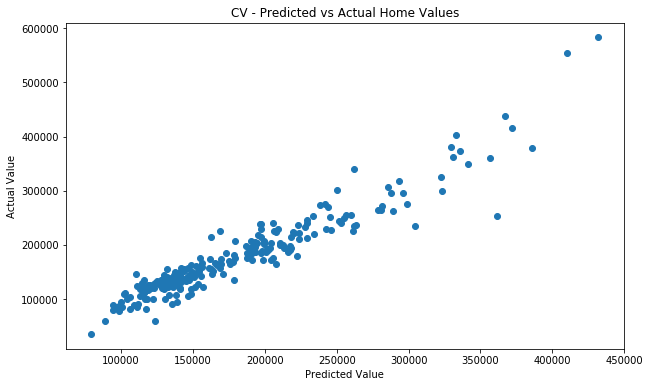

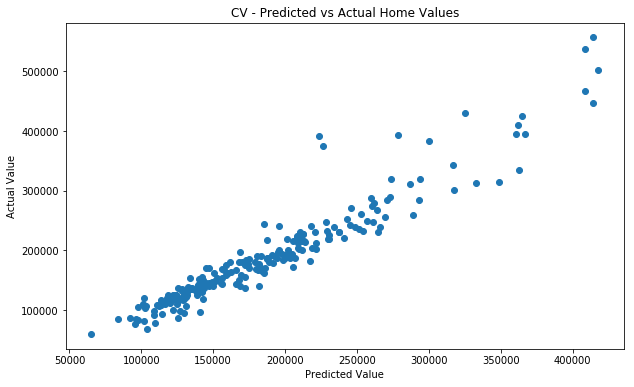

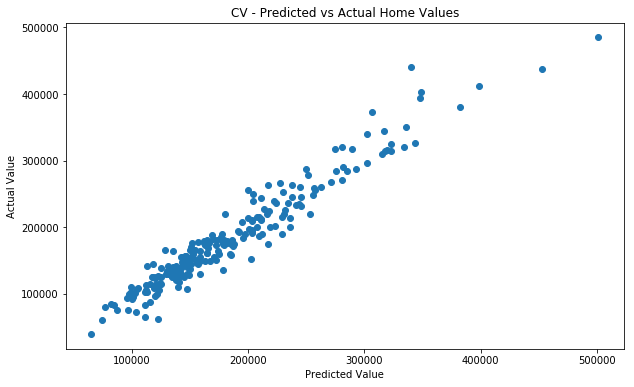

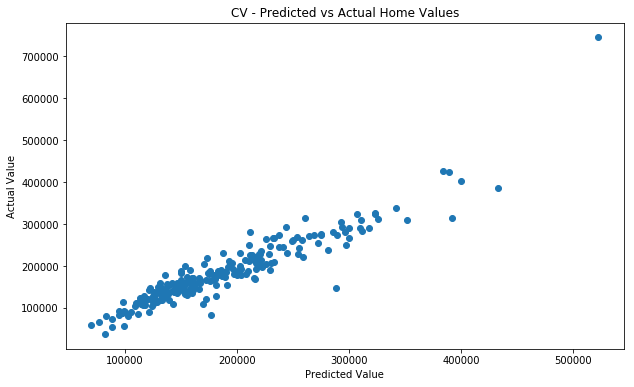

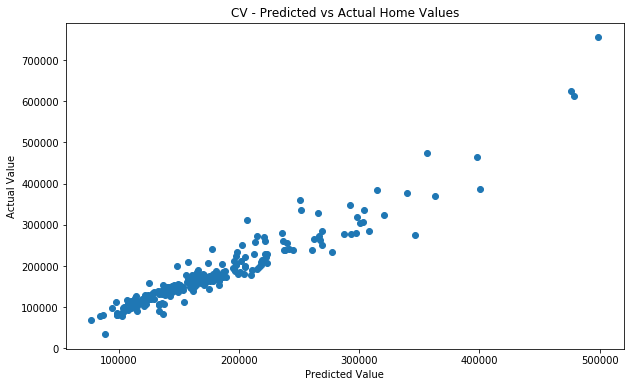

In [28]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()